In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shalinchakraborty","key":"bf81b7c6db4c63b86ee7827e88641839"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uom190346a/disease-symptoms-and-patient-profile-dataset

Dataset URL: https://www.kaggle.com/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset
License(s): CC0-1.0
  0% 0.00/3.07k [00:00<?, ?B/s]
100% 3.07k/3.07k [00:00<00:00, 6.49MB/s]


In [ ]:
!unzip disease-symptoms-and-patient-profile-dataset.zip

Archive:  disease-symptoms-and-patient-profile-dataset.zip
  inflating: Disease_symptom_and_patient_profile_dataset.csv  


In [ ]:
!pip install fastapi uvicorn pydantic

In [ ]:
!pip install catboost

In [99]:
# Base Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

# Data Analysis Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Machine Learning Library
from sklearn.ensemble import RandomForestClassifier

import pickle
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
from fastapi.middleware.cors import CORSMiddleware

# İgnore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv('Disease_symptom_and_patient_profile_dataset.csv')

In [ ]:
df.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


In [67]:
df.shape

(349, 10)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Disease               349 non-null    object
 1   Fever                 349 non-null    object
 2   Cough                 349 non-null    object
 3   Fatigue               349 non-null    object
 4   Difficulty Breathing  349 non-null    object
 5   Age                   349 non-null    int64 
 6   Gender                349 non-null    object
 7   Blood Pressure        349 non-null    object
 8   Cholesterol Level     349 non-null    object
 9   Outcome Variable      349 non-null    object
dtypes: int64(1), object(9)
memory usage: 27.4+ KB


In [87]:
df.isnull().sum()

,0
Disease,0
Fever,0
Cough,0
Fatigue,0
Difficulty Breathing,0
Age,0
Gender,0
Blood Pressure,0
Cholesterol Level,0
Outcome Variable,0


In [72]:
df.groupby(['Gender', 'Fever']).mean(numeric_only=True)

Age
Gender Fever           
Female No     44.797753
       Yes    46.804598
Male   No     48.223529
       Yes    45.556818

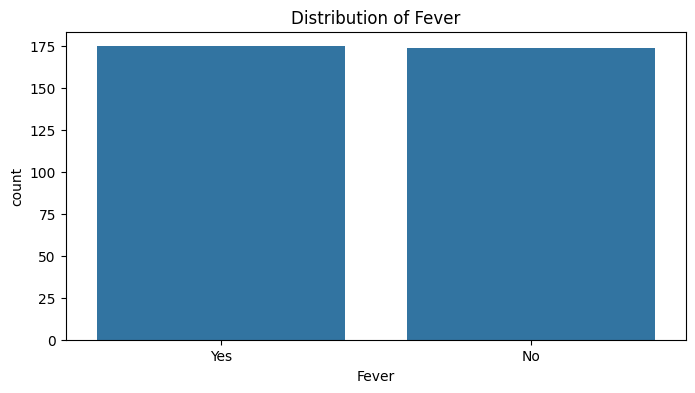

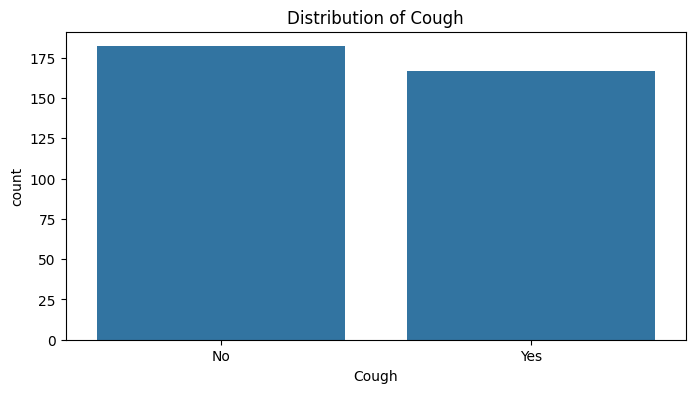

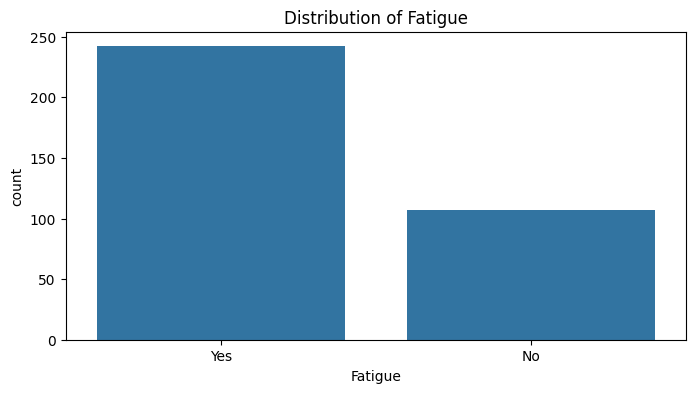

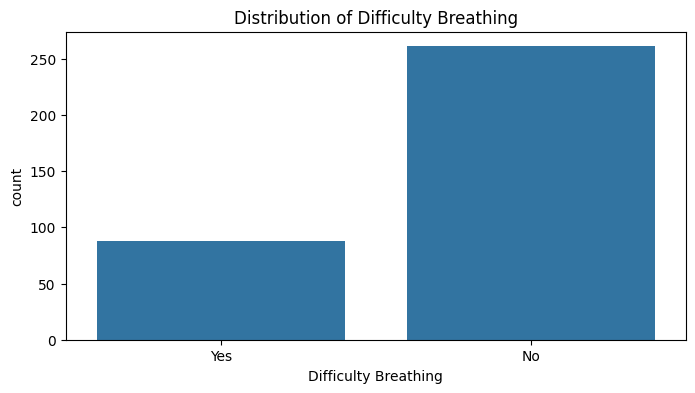

In [65]:
symptoms = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
for symptom in symptoms:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=symptom)
    plt.title(f'Distribution of {symptom}')
    plt.show()

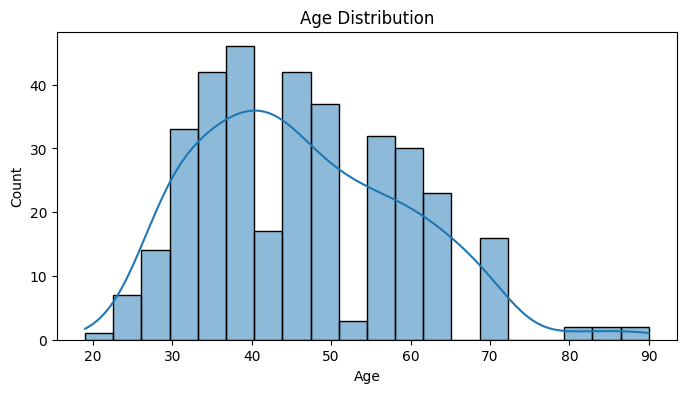

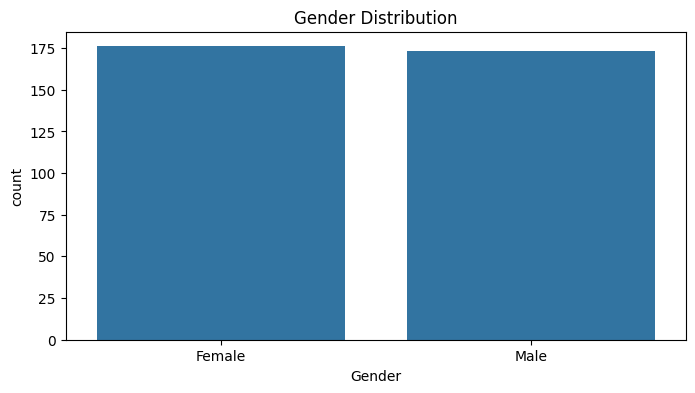

In [66]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Age', bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Gender')
plt.title('Gender Distribution')
plt.show()

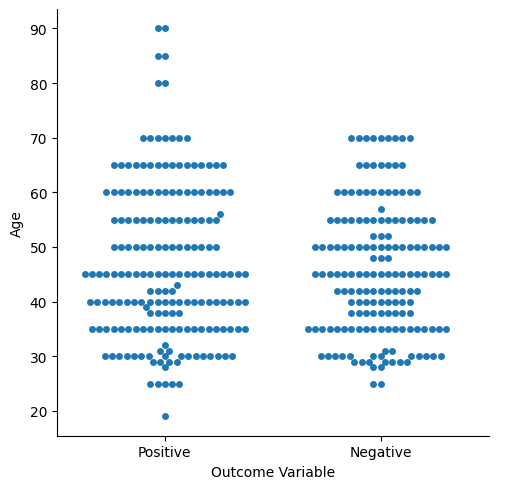

In [82]:
sns.catplot(x = 'Outcome Variable' , y = 'Age' , data = df , kind = "swarm")

In [89]:
X = df.drop('Outcome Variable', axis=1)
y = df['Outcome Variable']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8428571428571429

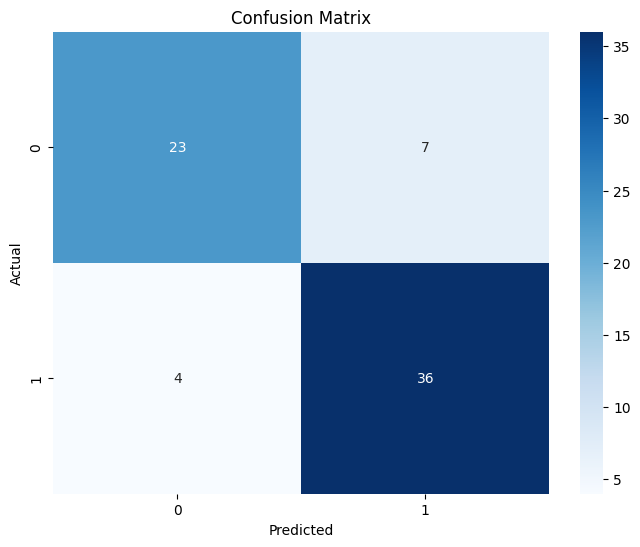

In [90]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

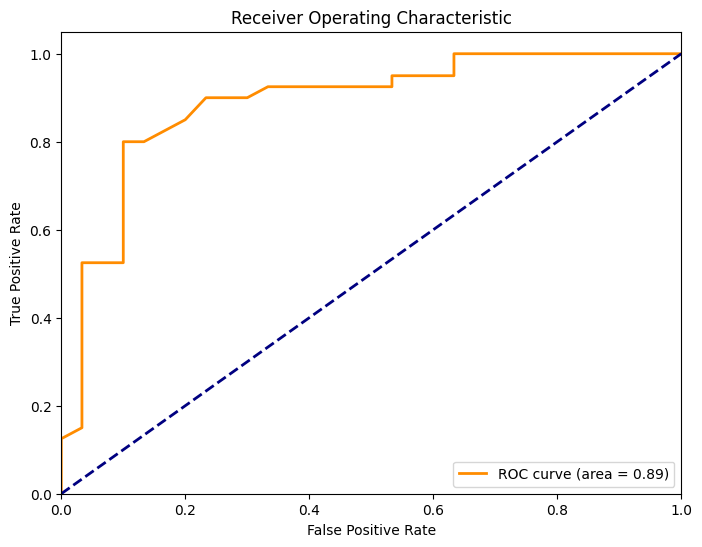

In [91]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=model.classes_[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [92]:
# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.8428571428571429
Precision: 0.8434846806939831
Recall: 0.8428571428571429
F1-Score: 0.8415617356644624


In [93]:
# Save the model
with open('disease_prediction_model.pkl', 'wb') as f:
    pickle.dump(model, f)